In [1]:
!pip install tensorflow
!pip install keras
!pip install pythainlp
!pip install full
!pip install emoji
!pip install attacut
import tensorflow
from gensim.models import Word2Vec,KeyedVectors
from tqdm import tqdm
import pandas as pd
import numpy as np
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GRU, LSTM,Bidirectional, Embedding, Dropout,BatchNormalization
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import pythainlp
from pythainlp.corpus import thai_stopwords
from pythainlp.tokenize import word_tokenize
import re
import string
from pythainlp.util import normalize
from pythainlp.tokenize import newmm

In [2]:
x_train = pd.read_csv('csv/x_train.csv',encoding='utf-8')
x_test = pd.read_csv('csv/x_test.csv',encoding='utf-8')
y_train = pd.read_csv('csv/y_train.csv',encoding='utf-8')
y_test = pd.read_csv('csv/y_test.csv',encoding='utf-8')

In [3]:
model = Word2Vec.load('model/w2v_model2.bin')

In [4]:
def cleanText(sentences):
    tokenized_sentences = []
    cleaned_sentences = []  # เพิ่มคอลัมน์เก็บประโยคที่ทำความสะอาดแล้ว
    
    for txt in sentences:
        # แปลงเป็น string
        t = str(txt)

        # ลบตัวอักษรที่ไม่ใช่ภาษาไทย
        cleaned_text = re.sub('[^ก-๙]', '', t)

        # Normalize ข้อความ (เช่น การปรับสระให้เป็นรูปแบบเดียวกัน)
        normalized_text = normalize(cleaned_text)

        # ดึง stopwords ภาษาไทย
        stop_words = set(thai_stopwords())

        # ตัดคำโดยใช้ engine "newmm" สำหรับการตัดคำภาษาไทย
        words = word_tokenize(normalized_text, engine="newmm")

        # ลบ stopwords และคำที่มีช่องว่าง
        filtered_words = [word for word in words if word not in stop_words and word.strip()]

        # แปลงเป็น lowercase
        tokenized_sentence = [word.lower() for word in filtered_words]

        # เก็บผลลัพธ์ของการตัดคำ
        tokenized_sentences.append(tokenized_sentence)

        # เก็บผลลัพธ์ของประโยคที่ทำความสะอาดแล้ว
        cleaned_sentence = " ".join(tokenized_sentence)
        cleaned_sentences.append(cleaned_sentence)

    return cleaned_sentences, tokenized_sentences  # คืนค่า 2 ค่า: ประโยคที่ทำความสะอาดแล้ว และการตัดคำ

In [5]:
!pip install imbalanced-learn

In [6]:
from imblearn.over_sampling import SMOTE

In [8]:
x_test['cleantext'], tokenized_sentences = cleanText(x_test['body'])
x_train['cleantext'], tokenized_sentences = cleanText(x_train['body'])

In [9]:
def get_average_vector(text):
    tokens = word_tokenize(text, engine="newmm")
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

In [10]:
X_train_vectors = [get_average_vector(text) for text in x_train['cleantext']]
X_test_vectors = [get_average_vector(text) for text in x_test['cleantext']]

In [11]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_vectors, y_train)

In [12]:
print(len(X_resampled), len(y_resampled))

12626 12626


Model Naive Bay

In [13]:
# นำเข้าไลบรารีที่จำเป็น
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.datasets import load_iris

In [14]:
# แบ่งข้อมูลเป็นชุดการฝึก (train) และทดสอบ (test)
X = X_resampled
y = y_resampled
X_resampled, X_test_vectors, y_resampled, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
# สร้างโมเดล Gaussian Naive Bayes
model = GaussianNB()

In [16]:
# กำหนดพารามิเตอร์ที่ต้องการปรับแต่ง (var_smoothing)
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]}
# ใช้ GridSearchCV เพื่อหาค่าพารามิเตอร์ที่ดีที่สุด
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

In [18]:
# เทรนโมเดลด้วยข้อมูลที่เตรียมไว้
y_resampled = y_resampled.to_numpy().ravel()  # หรือใช้ reshape(-1) แทนก็ได้

# เทรนโมเดลด้วยข้อมูลที่เตรียมไว้
grid_search.fit(X_resampled, y_resampled)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05,
                                           0.0001, 0.001]},
             scoring='accuracy')

In [19]:
# แสดงพารามิเตอร์ที่ดีที่สุด
print(f'Best Parameters: {grid_search.best_params_}')

# ทำนายผลบนชุดข้อมูลทดสอบ
y_pred = grid_search.best_estimator_.predict(X_test_vectors)

# แสดงผลลัพธ์ classification report
print(classification_report(y_test, y_pred))

Best Parameters: {'var_smoothing': 1e-09}
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1241
           1       0.85      0.89      0.87      1285

    accuracy                           0.86      2526
   macro avg       0.87      0.86      0.86      2526
weighted avg       0.87      0.86      0.86      2526



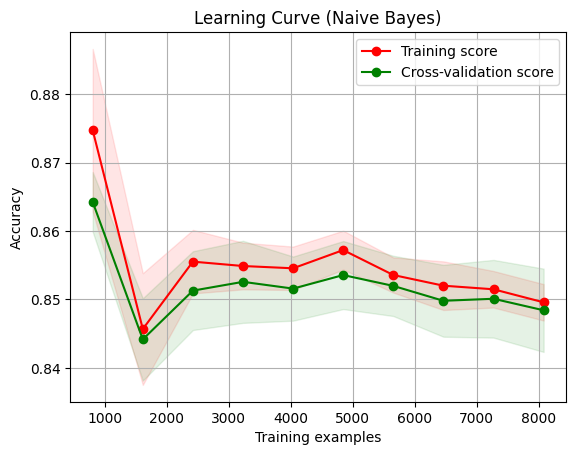

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris



# ฟังก์ชันเพื่อสร้าง learning curve
train_sizes, train_scores, test_scores = learning_curve(model, X_resampled, y_resampled, cv=5, scoring='accuracy',
                                                        train_sizes=np.linspace(0.1, 1.0, 10))

# คำนวณค่าเฉลี่ยและค่าเบี่ยงเบนมาตรฐานของ accuracy บนชุดเทรนและทดสอบ
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# สร้างกราฟ
plt.figure()
plt.title("Learning Curve (Naive Bayes)")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")

# พล็อตค่า accuracy ของเทรนและเทส
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()


Model SVM

In [21]:
# import SVC classifier
from sklearn.svm import SVC


# import metrics to compute accuracy
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.datasets import load_iris

In [22]:
# instantiate classifier with default hyperparameters
svm_model = SVC(
    C=1.0,
    kernel='rbf',
    gamma='scale',
    degree=3,
    coef0=0.0,
    shrinking=True,
    probability=False,
    tol=0.001,
    cache_size=200,
    class_weight=None,
    verbose=False,
    max_iter=-1,
    decision_function_shape='ovr',
    break_ties=False,
    random_state=42
)

In [25]:
# แปลง y_resampled ให้เป็น 1 มิติ ก่อนส่งเข้าโมเดล
y_resampled = y_resampled.ravel()  # หรือใช้ reshape(-1) แทนก็ได้

svm_model.fit(X_resampled, y_resampled)

SVC(random_state=42)

In [26]:
# make predictions on test set
y_pred = svm_model.predict(X_test_vectors)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1241
           1       0.98      0.96      0.97      1285

    accuracy                           0.97      2526
   macro avg       0.97      0.97      0.97      2526
weighted avg       0.97      0.97      0.97      2526



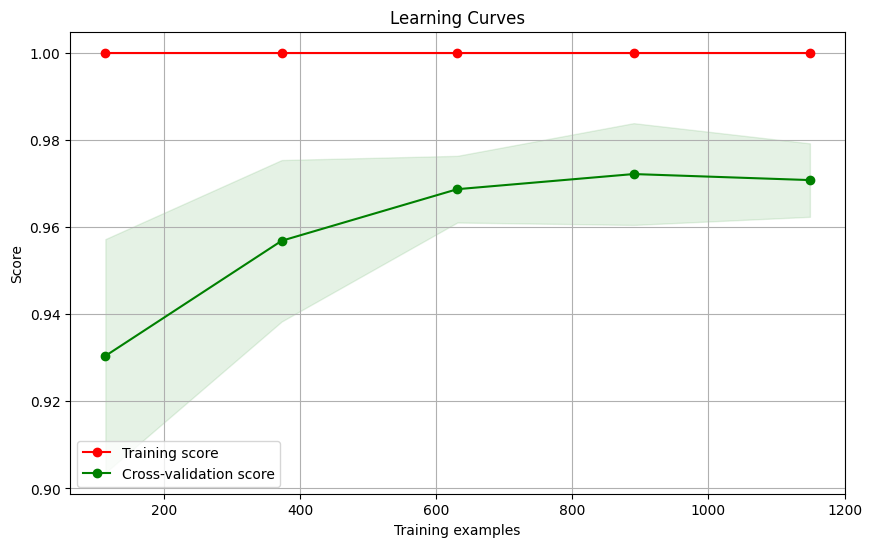

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
from sklearn.datasets import load_digits

# Load data
X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an SVM classifier
svm = SVC(kernel='linear')  # เปลี่ยน kernel ได้ตามต้องการ

# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    svm, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
)

# Calculate mean and standard deviation for training and test sets
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.title("Learning Curves")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid(True)

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()

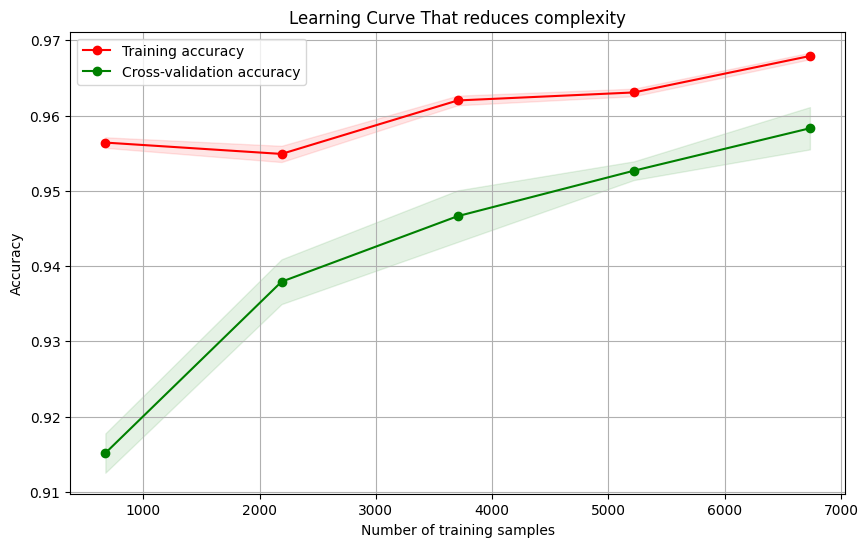

In [28]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split


# คำนวณ learning curve โดยลดความซับซ้อน
train_sizes, train_scores, test_scores = learning_curve(
    svm_model, X_resampled, y_resampled, cv=3, scoring='accuracy', n_jobs=1, train_sizes=np.linspace(0.1, 1.0, 5)
)

# คำนวณค่าเฉลี่ยและส่วนเบี่ยงเบนมาตรฐานสำหรับ training และ test set
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# วาดกราฟ Learning Curve
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training accuracy")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation accuracy")

# เพิ่ม labels และหัวข้อ
plt.xlabel("Number of training samples")
plt.ylabel("Accuracy")
plt.title("Learning Curve That reduces complexity")
plt.legend(loc="best")
plt.grid(True)
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the hyperparameters to tune
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']  # only needed for 'rbf' and 'poly'
}

In [ ]:
# Perform grid search
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_resampled, y_resampled.ravel())

In [ ]:
from sklearn.svm import LinearSVC

linear_svc = LinearSVC()  # Assign it to a variable called linear_svc
model = linear_svc  # Now you can use the variable


In [ ]:
from sklearn.svm import LinearSVC

# Initialize the model
linear_svc = LinearSVC()

# Fit the model with training data (this step is crucial)
linear_svc.fit(X_resampled, y_resampled)

# Now, you can use the score() method after fitting the model
print('Training set score: {:.4f}'.format(linear_svc.score(X_resampled, y_resampled)))
print('Test set score: {:.4f}'.format(linear_svc.score(X_test_vectors, y_test)))


Model Logistic

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [ ]:
clf = LogisticRegression(solver='lbfgs', max_iter=100, random_state=42)
clf.fit(X_resampled, y_resampled)

In [ ]:
y_pred = clf.predict(X_test_vectors)
print(classification_report(y_test, y_pred))

Model Landom

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# ใช้ Random Forest เป็นโมเดล
RF = RandomForestClassifier(random_state=42)
RF.fit(X_resampled, y_resampled)

In [ ]:
y_pred = RF.predict(X_test_vectors)
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.metrics import log_loss

In [ ]:
train_losses = []
val_losses = []

for i in range(1, 11):
    clf.max_iter = 100 * i
    clf.fit(X_resampled, y_resampled)
    
    # คำนวณ loss บน training set และ validation set
    train_loss = log_loss(y_resampled, clf.predict_proba(X_resampled))
    val_loss = log_loss(y_test, clf.predict_proba(X_test_vectors))
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# แสดงกราฟ
plt.plot(range(1, 11), train_losses, label='Training Loss')
plt.plot(range(1, 11), val_losses, label='Validation Loss')
plt.xlabel('Epochs (x10)')
plt.ylabel('Log Loss')
plt.title('Learning Curve - Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
train_losses = []
val_losses = []

for i in range(1, 11):
    RF.max_iter = 10 * i
    RF.fit(X_resampled, y_resampled)
    
    # คำนวณ loss บน training set และ validation set
    train_loss = log_loss(y_resampled, RF.predict_proba(X_resampled))
    val_loss = log_loss(y_test, RF.predict_proba(X_test_vectors))
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# แสดงกราฟ
plt.plot(range(1, 11), train_losses, label='Training Loss')
plt.plot(range(1, 11), val_losses, label='Validation Loss')
plt.xlabel('Epochs (x10)')
plt.ylabel('Log Loss')
plt.title('Learning Curve - Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score

# ประเมินโมเดลด้วย K-Fold Cross-Validation
scores = cross_val_score(clf, X_resampled, y_resampled, cv=5)  # 5-fold cross-validation
print(f"Cross-validation scores: {scores}")
print(f"Mean cross-validation score: {scores.mean()}")


In [ ]:
# ประเมินโมเดลด้วย K-Fold Cross-Validation
scores = cross_val_score(RF, X_resampled, y_resampled, cv=5)  # 5-fold cross-validation
print(f"Cross-validation scores: {scores}")
print(f"Mean cross-validation score: {scores.mean()}")